In [1]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# DALLE prompted dataset base line: custom cnn model
Check for GPU

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [3]:
data_dir = "./../data/dalle-prompted-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [5]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 1280 images belonging to 5 classes.


Get test data

In [6]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 318 images belonging to 5 classes.


Build model

model architecture based on: https://www.kaggle.com/code/tejaswi2003/20bd1a6637-weather-classification-cnn 

In [7]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(32,activation="relu",kernel_size=3,input_shape=(image_width, image_height, 3)))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(64,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(128,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(5,activation="softmax"))


Create model checkpoints

In [8]:
filepath = "./" + 'models/dalle_prompt_custom/dalle_prompt_custom_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [9]:
callbacks_list = [check_point]

In [10]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [11]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
80/80 [==============================] - 26s 258ms/step - loss: 1.4682 - accuracy: 0.3602 - val_loss: 1.3150 - val_accuracy: 0.4539

Epoch 00001: val_accuracy improved from -inf to 0.45395, saving model to ./models/dalle_prompt_custom\dalle_prompt_custom_01-0.4539.hdf5
Epoch 2/25
80/80 [==============================] - 22s 271ms/step - loss: 1.2251 - accuracy: 0.5188 - val_loss: 1.1706 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.45395 to 0.50000, saving model to ./models/dalle_prompt_custom\dalle_prompt_custom_02-0.5000.hdf5
Epoch 3/25
80/80 [==============================] - 14s 177ms/step - loss: 1.0826 - accuracy: 0.5977 - val_loss: 1.0707 - val_accuracy: 0.6184

Epoch 00003: val_accuracy improved from 0.50000 to 0.61842, saving model to ./models/dalle_prompt_custom\dalle_prompt_custom_03-0.6184.hdf5
Epoch 4/25
80/80 [==============================] - 14s 179ms/step - loss: 1.0016 - accuracy: 0.6141 - val_loss: 1.0192 - val_accuracy: 0.5954

Epoch 0

Evaluate model

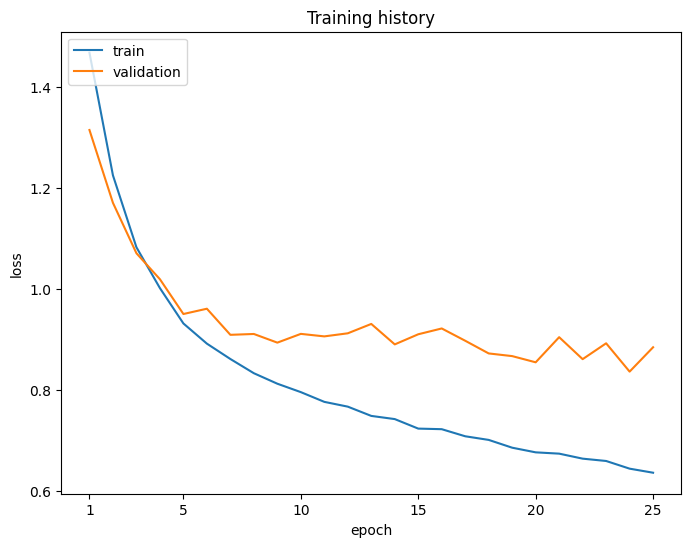

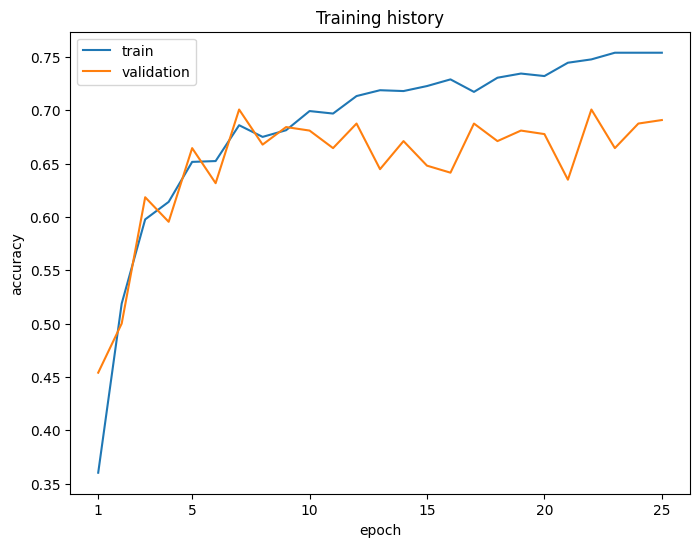

In [12]:
plot_history(history)

Load best model

In [13]:
model = keras.models.load_model("./models/dalle_prompt_custom/dalle_prompt_custom_07-0.7007.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

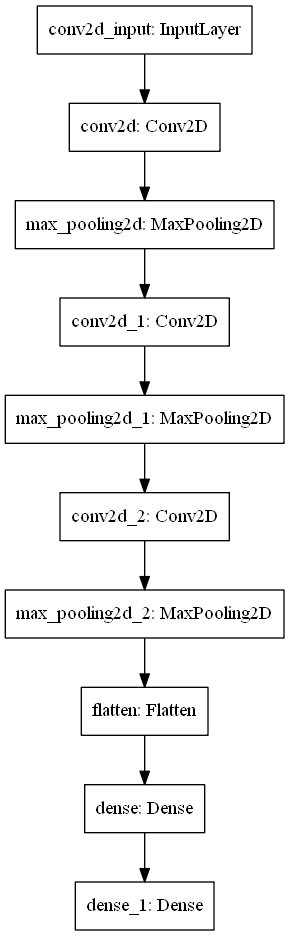

In [14]:
keras.utils.plot_model(model)

In [15]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[19 10  8 12 15]
 [14 15  7 10 18]
 [13 15 10 11 15]
 [15 14  6 19 10]
 [19 10  7 10 16]]


Class foggy:
    Sensitivity (TPR):  29.688% (19 of 64)
    Specificity (TNR):  75.984% (193 of 254)
    Precision:          23.750% (19 of 80)
    Neg. pred. value:   81.092% (193 of 238)
Class cloudy:
    Sensitivity (TPR):  23.438% (15 of 64)
    Specificity (TNR):  80.709% (205 of 254)
    Precision:          23.438% (15 of 64)
    Neg. pred. value:   80.709% (205 of 254)
Class sunny:
    Sensitivity (TPR):  15.625% (10 of 64)
    Specificity (TNR):  88.976% (226 of 254)
    Precision:          26.316% (10 of 38)
    Neg. pred. value:   80.714% (226 of 280)
Class snowy:
    Sensitivity (TPR):  29.688% (19 of 64)
    Specificity (TNR):  83.071% (211 of 254)
    Precision:          30.645% (19 of 62)
    Neg. pred. value:   82.422% (211 of 256)
Class rainy:
    Sensitivity (TPR):  25.806% (16 of 62)
    Specificity (TNR):  77.344% (198 of 256)
    Precision:          21.622% (16 of 74)
    Ne

array([[19, 10,  8, 12, 15],
       [14, 15,  7, 10, 18],
       [13, 15, 10, 11, 15],
       [15, 14,  6, 19, 10],
       [19, 10,  7, 10, 16]], dtype=int64)